# Assignment 4
# Sequences In Deep Learning

## RNN utils

In [0]:
import numpy as np

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def initialize_adam(parameters) :
    """
    Initializes v and s as two python dictionaries with:
                - keys: "dW1", "db1", ..., "dWL", "dbL" 
                - values: numpy arrays of zeros of the same shape as the corresponding gradients/parameters.
    
    Arguments:
    parameters -- python dictionary containing your parameters.
                    parameters["W" + str(l)] = Wl
                    parameters["b" + str(l)] = bl
    
    Returns: 
    v -- python dictionary that will contain the exponentially weighted average of the gradient.
                    v["dW" + str(l)] = ...
                    v["db" + str(l)] = ...
    s -- python dictionary that will contain the exponentially weighted average of the squared gradient.
                    s["dW" + str(l)] = ...
                    s["db" + str(l)] = ...

    """
    
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    s = {}
    
    # Initialize v, s. Input: "parameters". Outputs: "v, s".
    for l in range(L):
    ### START CODE HERE ### (approx. 4 lines)
        v["dW" + str(l+1)] = np.zeros(parameters["W" + str(l+1)].shape)
        v["db" + str(l+1)] = np.zeros(parameters["b" + str(l+1)].shape)
        s["dW" + str(l+1)] = np.zeros(parameters["W" + str(l+1)].shape)
        s["db" + str(l+1)] = np.zeros(parameters["b" + str(l+1)].shape)
    ### END CODE HERE ###
    
    return v, s


def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate = 0.01,
                                beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):
    """
    Update parameters using Adam
    
    Arguments:
    parameters -- python dictionary containing your parameters:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients for each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    v -- Adam variable, moving average of the first gradient, python dictionary
    s -- Adam variable, moving average of the squared gradient, python dictionary
    learning_rate -- the learning rate, scalar.
    beta1 -- Exponential decay hyperparameter for the first moment estimates 
    beta2 -- Exponential decay hyperparameter for the second moment estimates 
    epsilon -- hyperparameter preventing division by zero in Adam updates

    Returns:
    parameters -- python dictionary containing your updated parameters 
    v -- Adam variable, moving average of the first gradient, python dictionary
    s -- Adam variable, moving average of the squared gradient, python dictionary
    """
    
    L = len(parameters) // 2                 # number of layers in the neural networks
    v_corrected = {}                         # Initializing first moment estimate, python dictionary
    s_corrected = {}                         # Initializing second moment estimate, python dictionary
    
    # Perform Adam update on all parameters
    for l in range(L):
        # Moving average of the gradients. Inputs: "v, grads, beta1". Output: "v".
        ### START CODE HERE ### (approx. 2 lines)
        v["dW" + str(l+1)] = beta1 * v["dW" + str(l+1)] + (1 - beta1) * grads["dW" + str(l+1)] 
        v["db" + str(l+1)] = beta1 * v["db" + str(l+1)] + (1 - beta1) * grads["db" + str(l+1)] 
        ### END CODE HERE ###

        # Compute bias-corrected first moment estimate. Inputs: "v, beta1, t". Output: "v_corrected".
        ### START CODE HERE ### (approx. 2 lines)
        v_corrected["dW" + str(l+1)] = v["dW" + str(l+1)] / (1 - beta1**t)
        v_corrected["db" + str(l+1)] = v["db" + str(l+1)] / (1 - beta1**t)
        ### END CODE HERE ###

        # Moving average of the squared gradients. Inputs: "s, grads, beta2". Output: "s".
        ### START CODE HERE ### (approx. 2 lines)
        s["dW" + str(l+1)] = beta2 * s["dW" + str(l+1)] + (1 - beta2) * (grads["dW" + str(l+1)] ** 2)
        s["db" + str(l+1)] = beta2 * s["db" + str(l+1)] + (1 - beta2) * (grads["db" + str(l+1)] ** 2)
        ### END CODE HERE ###

        # Compute bias-corrected second raw moment estimate. Inputs: "s, beta2, t". Output: "s_corrected".
        ### START CODE HERE ### (approx. 2 lines)
        s_corrected["dW" + str(l+1)] = s["dW" + str(l+1)] / (1 - beta2 ** t)
        s_corrected["db" + str(l+1)] = s["db" + str(l+1)] / (1 - beta2 ** t)
        ### END CODE HERE ###

        # Update parameters. Inputs: "parameters, learning_rate, v_corrected, s_corrected, epsilon". Output: "parameters".
        ### START CODE HERE ### (approx. 2 lines)
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * v_corrected["dW" + str(l+1)] / np.sqrt(s_corrected["dW" + str(l+1)] + epsilon)
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * v_corrected["db" + str(l+1)] / np.sqrt(s_corrected["db" + str(l+1)] + epsilon)
        ### END CODE HERE ###

    return parameters, v, s

## RNN Forward

In [0]:
def rnn_cell_forward(xt, a_prev, parameters):
    """
    Implements a single forward step of the RNN-cell as described in Figure (2)

    Arguments:
    xt -- your input data at timestep "t", numpy array of shape (n_x, m).
    a_prev -- Hidden state at timestep "t-1", numpy array of shape (n_a, m)
    parameters -- python dictionary containing:
                        Wax -- Weight matrix multiplying the input, numpy array of shape (n_a, n_x)
                        Waa -- Weight matrix multiplying the hidden state, numpy array of shape (n_a, n_a)
                        Wya -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
                        ba --  Bias, numpy array of shape (n_a, 1)
                        by -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)
    Returns:
    a_next -- next hidden state, of shape (n_a, m)
    yt_pred -- prediction at timestep "t", numpy array of shape (n_y, m)
    cache -- tuple of values needed for the backward pass, contains (a_next, a_prev, xt, parameters)
    """
    
    # Retrieve parameters from "parameters"
    Wax = parameters["Wax"]
    Waa = parameters["Waa"]
    Wya = parameters["Wya"]
    ba = parameters["ba"]
    by = parameters["by"]
    
    ### START CODE HERE ### 
    # compute next activation state using the formula given above
    a_next = np.tanh(Wax.dot(xt) + Waa.dot(a_prev) + ba)
    # compute output of the current cell using the formula given above
    yt_pred = softmax(Wya.dot(a_next) + by)
    ### END CODE HERE ###
    
    # store values you need for backward propagation in cache
    cache = (a_next, a_prev, xt, parameters)
    
    return a_next, yt_pred, cache

In [60]:
np.random.seed(1)
xt = np.random.randn(3,10)
a_prev = np.random.randn(5,10)
Waa = np.random.randn(5,5)
Wax = np.random.randn(5,3)
Wya = np.random.randn(2,5)
ba = np.random.randn(5,1)
by = np.random.randn(2,1)
parameters = {"Waa": Waa, "Wax": Wax, "Wya": Wya, "ba": ba, "by": by}

a_next, yt_pred, cache = rnn_cell_forward(xt, a_prev, parameters)
print("a_next[4] = ", a_next[4])
print("a_next.shape = ", a_next.shape)
print("yt_pred[1] =", yt_pred[1])
print("yt_pred.shape = ", yt_pred.shape)

a_next[4] =  [ 0.59584544  0.18141802  0.61311866  0.99808218  0.85016201  0.99980978
 -0.18887155  0.99815551  0.6531151   0.82872037]
a_next.shape =  (5, 10)
yt_pred[1] = [0.9888161  0.01682021 0.21140899 0.36817467 0.98988387 0.88945212
 0.36920224 0.9966312  0.9982559  0.17746526]
yt_pred.shape =  (2, 10)


In [0]:
def rnn_forward(x, a0, parameters):
    """
    Implement the forward propagation of the recurrent neural network described in Figure (3).

    Arguments:
    x -- Input data for every time-step, of shape (n_x, m, T_x).
    a0 -- Initial hidden state, of shape (n_a, m)
    parameters -- python dictionary containing:
                        Waa -- Weight matrix multiplying the hidden state, numpy array of shape (n_a, n_a)
                        Wax -- Weight matrix multiplying the input, numpy array of shape (n_a, n_x)
                        Wya -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
                        ba --  Bias numpy array of shape (n_a, 1)
                        by -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)

    Returns:
    a -- Hidden states for every time-step, numpy array of shape (n_a, m, T_x)
    y_pred -- Predictions for every time-step, numpy array of shape (n_y, m, T_x)
    caches -- tuple of values needed for the backward pass, contains (list of caches, x)
    """
    
    # Initialize "caches" which will contain the list of all caches
    caches = []
    
    # Retrieve dimensions from shapes of x and Wy
    n_x, m, T_x = x.shape
    n_y, n_a = parameters["Wya"].shape
    
    ### START CODE HERE ###
    
    # initialize "a" and "y" with zeros
    a = np.zeros((n_a, m, T_x))
    y_pred = np.zeros((n_y, m, T_x))
    # Initialize a_next
    a_next = a0
    # loop over all time-steps
    for t in range(T_x):
        # Update next hidden state, compute the prediction, get the cache
        a_next, y, cache = rnn_cell_forward(x[:, :, t], a_next, parameters)
        # Save the value of the new "next" hidden state in a
        a[:, :, t] = a_next
        # Save the value of the prediction in y
        y_pred[:, :, t] = y
        # Append "cache" to "caches"
        caches.append(cache)
    ### END CODE HERE ###
    
    # store values needed for backward propagation in cache
    caches = (caches, x)
    
    return a, y_pred, caches

In [62]:
np.random.seed(1)
x = np.random.randn(3,10,4)
a0 = np.random.randn(5,10)
Waa = np.random.randn(5,5)
Wax = np.random.randn(5,3)
Wya = np.random.randn(2,5)
ba = np.random.randn(5,1)
by = np.random.randn(2,1)
parameters = {"Waa": Waa, "Wax": Wax, "Wya": Wya, "ba": ba, "by": by}

a, y_pred, caches = rnn_forward(x, a0, parameters)
print("a[4][1] = ", a[4][1])
print("a.shape = ", a.shape)
print("y_pred[1][3] =", y_pred[1][3])
print("y_pred.shape = ", y_pred.shape)
print("caches[1][1][3] =", caches[1][1][3])
print("len(caches) = ", len(caches))

a[4][1] =  [-0.99999375  0.77911235 -0.99861469 -0.99833267]
a.shape =  (5, 10, 4)
y_pred[1][3] = [0.79560373 0.86224861 0.11118257 0.81515947]
y_pred.shape =  (2, 10, 4)
caches[1][1][3] = [-1.1425182  -0.34934272 -0.20889423  0.58662319]
len(caches) =  2


## LSTM Forward

In [0]:
def lstm_cell_forward(xt, a_prev, c_prev, parameters):
    """
    Implement a single forward step of the LSTM-cell as described in Figure (4)

    Arguments:
    xt -- your input data at timestep "t", numpy array of shape (n_x, m).
    a_prev -- Hidden state at timestep "t-1", numpy array of shape (n_a, m)
    c_prev -- Memory state at timestep "t-1", numpy array of shape (n_a, m)
    parameters -- python dictionary containing:
                        Wf -- Weight matrix of the forget gate, numpy array of shape (n_a, n_a + n_x)
                        bf -- Bias of the forget gate, numpy array of shape (n_a, 1)
                        Wi -- Weight matrix of the update gate, numpy array of shape (n_a, n_a + n_x)
                        bi -- Bias of the update gate, numpy array of shape (n_a, 1)
                        Wc -- Weight matrix of the first "tanh", numpy array of shape (n_a, n_a + n_x)
                        bc -- Bias of the first "tanh", numpy array of shape (n_a, 1)
                        Wo -- Weight matrix of the output gate, numpy array of shape (n_a, n_a + n_x)
                        bo -- Bias of the output gate, numpy array of shape (n_a, 1)
                        Wy -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
                        by -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)
                        
    Returns:
    a_next -- next hidden state, of shape (n_a, m)
    c_next -- next memory state, of shape (n_a, m)
    yt_pred -- prediction at timestep "t", numpy array of shape (n_y, m)
    cache -- tuple of values needed for the backward pass, contains (a_next, c_next, a_prev, c_prev, xt, parameters)
    
    Note: ft/it/ot stand for the forget/update/output gates, cct stands for the candidate value (c tilde),
          c stands for the memory value
    """

    # Retrieve parameters from "parameters"
    Wf = parameters["Wf"]
    bf = parameters["bf"]
    Wi = parameters["Wi"]
    bi = parameters["bi"]
    Wc = parameters["Wc"]
    bc = parameters["bc"]
    Wo = parameters["Wo"]
    bo = parameters["bo"]
    Wy = parameters["Wy"]
    by = parameters["by"]
    
    # Retrieve dimensions from shapes of xt and Wy
    n_x, m = xt.shape
    n_y, n_a = Wy.shape

    ### START CODE HERE ###
    # Concatenate a_prev and xt 
    concat = np.concatenate((a_prev, xt), axis = 0)
    # Compute values for ft, it, cct, c_next, ot, a_next using the formulas given figure (4)
    ft = sigmoid(Wf.dot(concat) + bf)
    it = sigmoid(Wi.dot(concat) + bi)
    cct = np.tanh(Wc.dot(concat) + bc)
    c_next = ft * c_prev + it * cct
    ot = sigmoid(Wo.dot(concat) + bo)
    a_next = ot * np.tanh(c_next)
    # Compute prediction of the LSTM cell 
    yt_pred = softmax(Wy.dot(a_next) + by)
    ### END CODE HERE ###

    # store values needed for backward propagation in cache
    cache = (a_next, c_next, a_prev, c_prev, ft, it, cct, ot, xt, parameters)

    return a_next, c_next, yt_pred, cache

In [64]:
np.random.seed(1)
xt = np.random.randn(3,10)
a_prev = np.random.randn(5,10)
c_prev = np.random.randn(5,10)
Wf = np.random.randn(5, 5+3)
bf = np.random.randn(5,1)
Wi = np.random.randn(5, 5+3)
bi = np.random.randn(5,1)
Wo = np.random.randn(5, 5+3)
bo = np.random.randn(5,1)
Wc = np.random.randn(5, 5+3)
bc = np.random.randn(5,1)
Wy = np.random.randn(2,5)
by = np.random.randn(2,1)

parameters = {"Wf": Wf, "Wi": Wi, "Wo": Wo, "Wc": Wc, "Wy": Wy, "bf": bf, "bi": bi, "bo": bo, "bc": bc, "by": by}

a_next, c_next, yt, cache = lstm_cell_forward(xt, a_prev, c_prev, parameters)
print("a_next[4] = ", a_next[4])
print("a_next.shape = ", c_next.shape)
print("c_next[2] = ", c_next[2])
print("c_next.shape = ", c_next.shape)
print("yt[1] =", yt[1])
print("yt.shape = ", yt.shape)
print("cache[1][3] =", cache[1][3])
print("len(cache) = ", len(cache))

a_next[4] =  [-0.66408471  0.0036921   0.02088357  0.22834167 -0.85575339  0.00138482
  0.76566531  0.34631421 -0.00215674  0.43827275]
a_next.shape =  (5, 10)
c_next[2] =  [ 0.63267805  1.00570849  0.35504474  0.20690913 -1.64566718  0.11832942
  0.76449811 -0.0981561  -0.74348425 -0.26810932]
c_next.shape =  (5, 10)
yt[1] = [0.79913913 0.15986619 0.22412122 0.15606108 0.97057211 0.31146381
 0.00943007 0.12666353 0.39380172 0.07828381]
yt.shape =  (2, 10)
cache[1][3] = [-0.16263996  1.03729328  0.72938082 -0.54101719  0.02752074 -0.30821874
  0.07651101 -1.03752894  1.41219977 -0.37647422]
len(cache) =  10


In [0]:
def lstm_forward(x, a0, parameters):
    """
    Implement the forward propagation of the recurrent neural network using an LSTM-cell described in Figure (3).

    Arguments:
    x -- Input data for every time-step, of shape (n_x, m, T_x).
    a0 -- Initial hidden state, of shape (n_a, m)
    parameters -- python dictionary containing:
                        Wf -- Weight matrix of the forget gate, numpy array of shape (n_a, n_a + n_x)
                        bf -- Bias of the forget gate, numpy array of shape (n_a, 1)
                        Wi -- Weight matrix of the update gate, numpy array of shape (n_a, n_a + n_x)
                        bi -- Bias of the update gate, numpy array of shape (n_a, 1)
                        Wc -- Weight matrix of the first "tanh", numpy array of shape (n_a, n_a + n_x)
                        bc -- Bias of the first "tanh", numpy array of shape (n_a, 1)
                        Wo -- Weight matrix of the output gate, numpy array of shape (n_a, n_a + n_x)
                        bo -- Bias of the output gate, numpy array of shape (n_a, 1)
                        Wy -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
                        by -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)
                        
    Returns:
    a -- Hidden states for every time-step, numpy array of shape (n_a, m, T_x)
    y -- Predictions for every time-step, numpy array of shape (n_y, m, T_x)
    caches -- tuple of values needed for the backward pass, contains (list of all the caches, x)
    """

    # Initialize "caches", which will track the list of all the caches
    caches = []
    
    ### START CODE HERE ###
    # Retrieve dimensions from shapes of x and Wy 
    n_x, m, T_x = x.shape
    n_y, n_a = parameters["Wy"].shape
    # initialize "a", "c" and "y" with zeros
    a = np.zeros((n_a, m, T_x))
    c = np.zeros((n_a, m, T_x))
    y = np.zeros((n_y, m, T_x))
    # Initialize a_next and c_next
    a_next = a0 
    c_next = c[:, :, 0].copy()
    # loop over all time-steps
    for t in range(T_x):
        # Update next hidden state, next memory state, compute the prediction, get the cache 
        a_next, c_next, yt_pred, cache = lstm_cell_forward(x[:,:,t], a_next, c_next, parameters)
        # Save the value of the new "next" hidden state in a
        a[:,:,t] = a_next
        # Save the value of the prediction in y 
        y[:,:,t] = yt_pred
        # Save the value of the next cell state 
        c[:,:,t] = c_next
        # Append the cache into caches 
        caches.append(cache)
    ### END CODE HERE ###
    
    # store values needed for backward propagation in cache
    caches = (caches, x)

    return a, y, c, caches

In [66]:
np.random.seed(1)
x = np.random.randn(3,10,7)
a0 = np.random.randn(5,10)
Wf = np.random.randn(5, 5+3)
bf = np.random.randn(5,1)
Wi = np.random.randn(5, 5+3)
bi = np.random.randn(5,1)
Wo = np.random.randn(5, 5+3)
bo = np.random.randn(5,1)
Wc = np.random.randn(5, 5+3)
bc = np.random.randn(5,1)
Wy = np.random.randn(2,5)
by = np.random.randn(2,1)

parameters = {"Wf": Wf, "Wi": Wi, "Wo": Wo, "Wc": Wc, "Wy": Wy, "bf": bf, "bi": bi, "bo": bo, "bc": bc, "by": by}

a, y, c, caches = lstm_forward(x, a0, parameters)
print("a[4][3][6] = ", a[4][3][6])
print("a.shape = ", a.shape)
print("y[1][4][3] =", y[1][4][3])
print("y.shape = ", y.shape)
print("caches[1][1[1]] =", caches[1][1][1])
print("c[1][2][1]", c[1][2][1])
print("len(caches) = ", len(caches))

a[4][3][6] =  0.17211776753291672
a.shape =  (5, 10, 7)
y[1][4][3] = 0.9508734618501101
y.shape =  (2, 10, 7)
caches[1][1[1]] = [ 0.82797464  0.23009474  0.76201118 -0.22232814 -0.20075807  0.18656139
  0.41005165]
c[1][2][1] -0.8555449167181981
len(caches) =  2


### GRU Forward

In [0]:
def gru_cell_forward(xt, c_prev, parameters):
    """
    Implement a single forward step of the GRU-cell

    Arguments:
    xt -- your input data at timestep "t", numpy array of shape (n_x, m).
    c_prev -- Memory state at timestep "t-1", numpy array of shape (n_a, m)
    parameters -- python dictionary containing:
                        Wu -- Weight matrix of the relevant gate, numpy array of shape (n_a, n_a + n_x)
                        bu -- Bias of the relevant gate, numpy array of shape (n_a, 1)
                        Wr -- Weight matrix of the reset gate, numpy array of shape (n_a, n_a + n_x)
                        br -- Bias of the reset gate, numpy array of shape (n_a, 1)
                        Wc -- Weight matrix of the first "tanh", numpy array of shape (n_a, n_a + n_x)
                        bc -- Bias of the first "tanh", numpy array of shape (n_a, 1)
                        Wy -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
                        by -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)
                        
    Returns:
    c_next -- next memory state, of shape (n_a, m)
    yt_pred -- prediction at timestep "t", numpy array of shape (n_y, m)
    cache -- tuple of values needed for the backward pass, contains (a_next, c_next, a_prev, c_prev, xt, parameters)
    
    Note: ut/rt stand for the relevant/reset gates, cct stands for the candidate value (c tilde),
          c stands for the memory value
    """

    # Retrieve parameters from "parameters"
    Wu = parameters["Wu"]
    bu = parameters["bu"]
    Wr = parameters["Wr"]
    br = parameters["br"]
    Wc = parameters["Wc"]
    bc = parameters["bc"]
    Wy = parameters["Wy"]
    by = parameters["by"]
    
    # Retrieve dimensions from shapes of xt and Wy
    n_x, m = xt.shape
    n_y, n_a = Wy.shape

    ### START CODE HERE ###
    # Concatenate c_prev and xt 
    concat = np.concatenate((c_prev, xt), axis = 0)
    # Compute values for ut, rt, cct, c_next, a_next
    ut = sigmoid(Wu.dot(concat) + bu)
    rt = sigmoid(Wr.dot(concat) + br)
    cct = np.tanh(Wc.dot(np.concatenate((rt * c_prev, xt), axis = 0)) + bc)
    c_next = ut * cct + (1 - ut) * c_prev
    a_next = c_next
    # Compute prediction of the GRU cell 
    yt_pred = softmax(Wy.dot(a_next) + by)
    ### END CODE HERE ###
    # store values needed for backward propagation in cache
    cache = (a_next, c_next, c_prev, ut, rt, cct , xt, parameters)

    return c_next, yt_pred, cache

In [68]:
np.random.seed(1)
xt = np.random.randn(3,10)
c_prev = np.random.randn(5,10)
Wu = np.random.randn(5, 5+3)
bu = np.random.randn(5,1)
Wr = np.random.randn(5, 5+3)
br = np.random.randn(5,1)
Wc = np.random.randn(5, 5+3)
bc = np.random.randn(5,1)
Wy = np.random.randn(2,5)
by = np.random.randn(2,1)

parameters = {"Wu": Wu, "Wr": Wr, "Wc": Wc, "Wy": Wy, "bu": bu, "br": br, "bc": bc, "by": by}

c_next, yt, cache = gru_cell_forward(xt, c_prev, parameters)
print("c_next[2] = ", c_next[2])
print("c_next.shape = ", c_next.shape)
print("yt[1] =", yt[1])
print("yt.shape = ", yt.shape)
print("cache[1][3] =", cache[1][3])
print("len(cache) = ", len(cache))

c_next[2] =  [ 0.96835301 -0.88762039  0.62503132  0.01958295  0.97551784  0.38587312
  0.88733595  0.24367956  0.82957926  0.92582788]
c_next.shape =  (5, 10)
yt[1] = [0.75531427 0.00261152 0.04392701 0.03915876 0.09527215 0.2514967
 0.1331264  0.10993315 0.01768743 0.53323971]
yt.shape =  (2, 10)
cache[1][3] = [-0.45979987  0.95361345  0.44527489 -0.9784312   0.54871199 -0.97785524
  0.92927724 -0.68982212  1.99551341 -0.49854442]
len(cache) =  8


In [0]:
def gru_forward(x, c0, parameters):
    """
    Implement the forward propagation of the recurrent neural network using an GRU-cell.

    Arguments:
    x -- Input data for every time-step, of shape (n_x, m, T_x).
    c0 -- Initial hidden state, of shape (n_a, m)
    parameters -- python dictionary containing:
                        Wu -- Weight matrix of the relevant gate, numpy array of shape (n_a, n_a + n_x)
                        bu -- Bias of the relevant gate, numpy array of shape (n_a, 1)
                        Wr -- Weight matrix of the reset gate, numpy array of shape (n_a, n_a + n_x)
                        br -- Bias of the reset gate, numpy array of shape (n_a, 1)
                        Wc -- Weight matrix of the first "tanh", numpy array of shape (n_a, n_a + n_x)
                        bc -- Bias of the first "tanh", numpy array of shape (n_a, 1)
                        Wy -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
                        by -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)
                        
    Returns:
    c -- Hidden states for every time-step, numpy array of shape (n_a, m, T_x)
    y -- Predictions for every time-step, numpy array of shape (n_y, m, T_x)
    caches -- tuple of values needed for the backward pass, contains (list of all the caches, x)
    """

    # Initialize "caches", which will track the list of all the caches
    caches = []
    
    ### START CODE HERE ###
    # Retrieve dimensions from shapes of x and Wy 
    n_x, m, T_x = x.shape
    n_y, n_a = parameters["Wy"].shape
    # initialize "a", "c" and "y" with zeros
    c = np.zeros((n_a, m, T_x))
    y = np.zeros((n_y, m, T_x))
    # Initialize a_next and c_next
    c_next = c0
    # loop over all time-steps
    for t in range(T_x):
        # Update next hidden state, next memory state, compute the prediction, get the cache 
        c_next, yt_pred, cache = gru_cell_forward(x[:,:,t], c_next, parameters)
        # Save the value of the prediction in y 
        y[:,:,t] = yt_pred
        # Save the value of the next cell state 
        c[:,:,t] = c_next
        # Append the cache into caches 
        caches.append(cache)
    ### END CODE HERE ###
    
    # store values needed for backward propagation in cache
    caches = (caches, x)

    return y, c, caches

In [70]:
np.random.seed(1)
x = np.random.randn(3,10,7)
c0 = np.random.randn(5,10)
Wu = np.random.randn(5, 5+3)
bu = np.random.randn(5,1)
Wr = np.random.randn(5, 5+3)
br = np.random.randn(5,1)
Wc = np.random.randn(5, 5+3)
bc = np.random.randn(5,1)
Wy = np.random.randn(2,5)
by = np.random.randn(2,1)

parameters = {"Wr": Wr, "Wu": Wu, "Wc": Wc, "Wy": Wy, "br": br, "bu": bu, "bc": bc, "by": by}

y, c, caches = gru_forward(x, c0, parameters)
print("y[1][4][3] =", y[1][4][3])
print("y.shape = ", y.shape)
print("caches[1][1[1]] =", caches[1][1][1])
print("c[1][2][1]", c[1][2][1])
print("len(caches) = ", len(caches))

y[1][4][3] = 0.41095408633521757
y.shape =  (2, 10, 7)
caches[1][1[1]] = [ 0.82797464  0.23009474  0.76201118 -0.22232814 -0.20075807  0.18656139
  0.41005165]
c[1][2][1] 1.5179668926616001
len(caches) =  2


## RNN Backward

In [0]:
def rnn_cell_backward(da_next, cache):
    """
    Implements the backward pass for the RNN-cell (single time-step).

    Arguments:
    da_next -- Gradient of loss with respect to next hidden state
    cache -- python dictionary containing useful values (output of rnn_cell_forward())

    Returns:
    gradients -- python dictionary containing:
                        dx -- Gradients of input data, of shape (n_x, m)
                        da_prev -- Gradients of previous hidden state, of shape (n_a, m)
                        dWax -- Gradients of input-to-hidden weights, of shape (n_a, n_x)
                        dWaa -- Gradients of hidden-to-hidden weights, of shape (n_a, n_a)
                        dba -- Gradients of bias vector, of shape (n_a, 1)
    """
    
    # Retrieve values from cache
    (a_next, a_prev, xt, parameters) = cache
    
    # Retrieve values from parameters
    Wax = parameters["Wax"]
    Waa = parameters["Waa"]
    Wya = parameters["Wya"]
    ba = parameters["ba"]
    by = parameters["by"]

    ### START CODE HERE ###
   # compute the gradient of tanh with respect to a_next
    dtanh = 1 - (a_next ** 2)
    # compute the gradient of the loss with respect to Wax
    dxt = np.dot(Wax.T, da_next * dtanh)
    dWax = np.dot(da_next * dtanh, xt.T)

    # compute the gradient with respect to Waa
    da_prev = np.dot(Waa.T, da_next * dtanh)
    dWaa = np.dot(da_next * dtanh, a_prev.T)

    # compute the gradient with respect to b
    dba = np.sum(dtanh * da_next, axis = 1).reshape((a_next.shape[0],1))

    ### END CODE HERE ###
    
    # Store the gradients in a python dictionary
    gradients = {"dxt": dxt, "da_prev": da_prev, "dWax": dWax, "dWaa": dWaa, "dba": dba}
    
    return gradients

In [72]:
np.random.seed(1)
xt = np.random.randn(3,10)
a_prev = np.random.randn(5,10)
Wax = np.random.randn(5,3)
Waa = np.random.randn(5,5)
Wya = np.random.randn(2,5)
b = np.random.randn(5,1)
by = np.random.randn(2,1)
parameters = {"Wax": Wax, "Waa": Waa, "Wya": Wya, "ba": ba, "by": by}

a_next, yt, cache = rnn_cell_forward(xt, a_prev, parameters)

da_next = np.random.randn(5,10)
gradients = rnn_cell_backward(da_next, cache)
print("gradients[\"dxt\"][1][2] =", gradients["dxt"][1][2])
print("gradients[\"dxt\"].shape =", gradients["dxt"].shape)
print("gradients[\"da_prev\"][2][3] =", gradients["da_prev"][2][3])
print("gradients[\"da_prev\"].shape =", gradients["da_prev"].shape)
print("gradients[\"dWax\"][3][1] =", gradients["dWax"][3][1])
print("gradients[\"dWax\"].shape =", gradients["dWax"].shape)
print("gradients[\"dWaa\"][1][2] =", gradients["dWaa"][1][2])
print("gradients[\"dWaa\"].shape =", gradients["dWaa"].shape)
print("gradients[\"dba\"][4] =", gradients["dba"][4])
print("gradients[\"dba\"].shape =", gradients["dba"].shape)

gradients["dxt"][1][2] = -0.4605641030588796
gradients["dxt"].shape = (3, 10)
gradients["da_prev"][2][3] = 0.08429686538067724
gradients["da_prev"].shape = (5, 10)
gradients["dWax"][3][1] = 0.39308187392193034
gradients["dWax"].shape = (5, 3)
gradients["dWaa"][1][2] = -0.28483955786960663
gradients["dWaa"].shape = (5, 5)
gradients["dba"][4] = [0.80517166]
gradients["dba"].shape = (5, 1)


In [0]:
def rnn_backward(da, caches):
    """
    Implement the backward pass for a RNN over an entire sequence of input data.

    Arguments:
    da -- Upstream gradients of all hidden states, of shape (n_a, m, T_x)
    caches -- tuple containing information from the forward pass (rnn_forward)
    
    Returns:
    gradients -- python dictionary containing:
                        dx -- Gradient w.r.t. the input data, numpy-array of shape (n_x, m, T_x)
                        da0 -- Gradient w.r.t the initial hidden state, numpy-array of shape (n_a, m)
                        dWax -- Gradient w.r.t the input's weight matrix, numpy-array of shape (n_a, n_x)
                        dWaa -- Gradient w.r.t the hidden state's weight matrix, numpy-arrayof shape (n_a, n_a)
                        dba -- Gradient w.r.t the bias, of shape (n_a, 1)
    """
        
    ### START CODE HERE ###
    
    # Retrieve values from the first cache (t=1) of caches
    (caches, x) = caches
    (a1, a0, x1, parameters) = caches[0]
    
    # Retrieve dimensions from da's and x1's shapes 
    n_a, m, T_x = da.shape
    n_x, m = x1.shape
    
    # initialize the gradients with the right sizes 
    dx = np.zeros(x.shape)
    dWax = np.zeros(parameters['Wax'].shape)
    dWaa = np.zeros(parameters['Waa'].shape)
    dba = np.zeros(parameters['ba'].shape)
    da0 = np.zeros(a0.shape)
    da_prevt = np.zeros(a0.shape)
    
    # Loop through all the time steps
    for t in reversed(range(T_x)):
        # Compute gradients at time step t. Choose wisely the "da_next" and the "cache" to use in the backward propagation step.
        gradients =  rnn_cell_backward(da[:,:,t] + da_prevt, caches[t])
        # Retrieve derivatives from gradients
        dxt, da_prevt, dWaxt, dWaat, dbat = gradients["dxt"], gradients["da_prev"], gradients["dWax"], gradients["dWaa"], gradients["dba"]
        # Increment global derivatives w.r.t parameters by adding their derivative at time-step t
        dx[:, :, t] = dxt
        dWax += dWaxt
        dWaa += dWaat
        dba += dbat
    # Set da0 to the gradient of a which has been backpropagated through all time-steps 
    da0 = da_prevt
    ### END CODE HERE ###

    # Store the gradients in a python dictionary
    gradients = {"dx": dx, "da0": da0, "dWax": dWax, "dWaa": dWaa,"dba": dba}
    
    return gradients

In [74]:
np.random.seed(1)
x = np.random.randn(3,10,4)
a0 = np.random.randn(5,10)
Wax = np.random.randn(5,3)
Waa = np.random.randn(5,5)
Wya = np.random.randn(2,5)
ba = np.random.randn(5,1)
by = np.random.randn(2,1)
parameters = {"Wax": Wax, "Waa": Waa, "Wya": Wya, "ba": ba, "by": by}
a, y, caches = rnn_forward(x, a0, parameters)
da = np.random.randn(5, 10, 4)
gradients = rnn_backward(da, caches)

print("gradients[\"dx\"][1][2] =", gradients["dx"][1][2])
print("gradients[\"dx\"].shape =", gradients["dx"].shape)
print("gradients[\"da0\"][2][3] =", gradients["da0"][2][3])
print("gradients[\"da0\"].shape =", gradients["da0"].shape)
print("gradients[\"dWax\"][3][1] =", gradients["dWax"][3][1])
print("gradients[\"dWax\"].shape =", gradients["dWax"].shape)
print("gradients[\"dWaa\"][1][2] =", gradients["dWaa"][1][2])
print("gradients[\"dWaa\"].shape =", gradients["dWaa"].shape)
print("gradients[\"dba\"][4] =", gradients["dba"][4])
print("gradients[\"dba\"].shape =", gradients["dba"].shape)


gradients["dx"][1][2] = [-2.07101689 -0.59255627  0.02466855  0.01483317]
gradients["dx"].shape = (3, 10, 4)
gradients["da0"][2][3] = -0.31494237512664996
gradients["da0"].shape = (5, 10)
gradients["dWax"][3][1] = 11.264104496527777
gradients["dWax"].shape = (5, 3)
gradients["dWaa"][1][2] = 2.303333126579893
gradients["dWaa"].shape = (5, 5)
gradients["dba"][4] = [-0.74747722]
gradients["dba"].shape = (5, 1)


## GRU Backward

In [0]:
def gru_cell_backward(da_next, cache):
    """
    Implements the backward pass for the RNN-cell (single time-step).

    Arguments:
    da_next -- Gradient of loss with respect to next hidden state
    cache -- python dictionary containing useful values (output of rnn_cell_forward())

    Returns:
    gradients -- python dictionary containing:
                        dx -- Gradients of input data, of shape (n_x, m)
                        da_prev -- Gradients of previous hidden state, of shape (n_a, m)
                        dWax -- Gradients of input-to-hidden weights, of shape (n_a, n_x)
                        dWaa -- Gradients of hidden-to-hidden weights, of shape (n_a, n_a)
                        dba -- Gradients of bias vector, of shape (n_a, 1)
    """
    
    # Retrieve values from cache
    (a_next, c_next, c_prev, ut, rt, cct , xt, parameters) = cache
    
    # Retrieve parameters from "parameters"
    Wu = parameters["Wu"]
    bu = parameters["bu"]
    Wr = parameters["Wr"]
    br = parameters["br"]
    Wc = parameters["Wc"]
    bc = parameters["bc"]
    Wy = parameters["Wy"]
    by = parameters["by"]
    n_x, m = xt.shape
    n_c, _ = c_prev.shape
    ### START CODE HERE ###
    c_diff = (cct - c_prev)
    cx = np.concatenate((c_prev, xt), axis = 0)
    rcx = np.concatenate((c_prev * rt, xt), axis = 0)
    c0 = np.concatenate((c_prev, np.zeros(xt.shape)), axis = 0)
    r0 = np.concatenate((rt, np.zeros(xt.shape)), axis = 0)
    dWu = (da_next * c_diff * ut * (1 - ut)).dot(cx.T)
    dbu = np.sum(da_next * c_diff * ut * (1 - ut), axis = 1).reshape((-1, 1))
    dWr = (da_next * ut * ( 1 - cct**2) * rt * (1 - rt) * Wc.dot(c0)).dot(cx.T) 
    dbr = np.sum(da_next * ut * ( 1 - cct**2) * rt * (1 - rt) * Wc.dot(c0), axis = 1).reshape((-1, 1))
    dWc = (da_next * ut * (1 - cct**2)).dot(rcx.T)
    dbc = np.sum(da_next * ut * (1 - cct**2), axis = 1).reshape((-1, 1))
    da_prev = da_next * (1 - ut) + Wu[:,:n_c].T.dot(da_next * c_diff * ut * (1 - ut)) + da_next * ut * (1 - cct**2) * Wc.dot(r0) + Wr[:,:n_c].T.dot(da_next * ut * (1 - cct ** 2) * Wc.dot(c0) * rt * (1 - rt))
    dxt = Wu[:,n_c:].T.dot(da_next * c_diff * ut * (1 - ut)) + Wc[:,n_c:].T.dot(da_next * ut * (1 - cct**2)) + Wr[:,n_c:].T.dot(da_next * ut * (1 - cct**2) * Wc.dot(c0) * rt * (1-rt))
    ### END CODE HERE ###
    
    # Store the gradients in a python dictionary
    gradients = {"dxt": dxt, "da_prev": da_prev, "dc_prev": da_prev, "dWu": dWu, "dWr": dWr, "dWc": dWc, "dbc": dbc, "dbu": dbu, "dbr": dbr}
    
    return gradients

In [212]:
np.random.seed(1)
xt = np.random.randn(3,10)
c_prev = np.random.randn(5,10)
Wu = np.random.randn(5, 5+3)
bu = np.random.randn(5,1)
Wr = np.random.randn(5, 5+3)
br = np.random.randn(5,1)
Wc = np.random.randn(5, 5+3)
bc = np.random.randn(5,1)
Wy = np.random.randn(2,5)
by = np.random.randn(2,1)

parameters = {"Wu": Wu, "Wr": Wr, "Wc": Wc, "Wy": Wy, "bu": bu, "br": br, "bc": bc, "by": by}

c_next, yt, cache = gru_cell_forward(xt, c_prev, parameters)

da_next = np.random.randn(5,10)
gradients = gru_cell_backward(da_next, cache)
print("gradients[\"dxt\"][1][2] =", gradients["dxt"][1][2])
print("gradients[\"dxt\"].shape =", gradients["dxt"].shape)
print("gradients[\"da_prev\"][2][3] =", gradients["da_prev"][2][3])
print("gradients[\"da_prev\"].shape =", gradients["da_prev"].shape)
print("gradients[\"dWu\"][3][1] =", gradients["dWu"][3][1])
print("gradients[\"dWu\"].shape =", gradients["dWu"].shape)
print("gradients[\"dWc\"][1][2] =", gradients["dWc"][1][2])
print("gradients[\"dWc\"].shape =", gradients["dWc"].shape)
print("gradients[\"dbr\"][4] =", gradients["dbr"][4])
print("gradients[\"dbr\"].shape =", gradients["dbr"].shape)

gradients["dxt"][1][2] = -0.5587102488376965
gradients["dxt"].shape = (3, 10)
gradients["da_prev"][2][3] = 0.07043422916503733
gradients["da_prev"].shape = (5, 10)
gradients["dWu"][3][1] = -0.0907624548994332
gradients["dWu"].shape = (5, 8)
gradients["dWc"][1][2] = -0.28268841181863846
gradients["dWc"].shape = (5, 8)
gradients["dbr"][4] = [0.08794573]
gradients["dbr"].shape = (5, 1)


In [0]:
def gru_backward(da, caches):
    """
    Implement the backward pass for a RNN over an entire sequence of input data.

    Arguments:
    da -- Upstream gradients of all hidden states, of shape (n_a, m, T_x)
    caches -- tuple containing information from the forward pass (rnn_forward)
    
    Returns:
    gradients -- python dictionary containing:
                        dx -- Gradient w.r.t. the input data, numpy-array of shape (n_x, m, T_x)
                        da0 -- Gradient w.r.t the initial hidden state, numpy-array of shape (n_a, m)
                        dWax -- Gradient w.r.t the input's weight matrix, numpy-array of shape (n_a, n_x)
                        dWaa -- Gradient w.r.t the hidden state's weight matrix, numpy-arrayof shape (n_a, n_a)
                        dba -- Gradient w.r.t the bias, of shape (n_a, 1)
    """
        
    ### START CODE HERE ###
    
     # Retrieve values from the first cache (t=1) of caches
    (caches, x) = caches
    (a_next, c_next, c_prev, ut, rt, cct , xt, parameters) = caches[0] 
    
    # Retrieve dimensions from da's and x1's shapes 
    n_a, m, T_x = da.shape
    n_x, m = xt.shape
    
    # initialize the gradients with the right sizes 
    dx = np.zeros(x.shape)
    dWu = np.zeros(parameters['Wu'].shape)
    dWr = np.zeros(parameters['Wr'].shape)
    dWc = np.zeros(parameters['Wc'].shape)
    dbu = np.zeros(parameters['bu'].shape)
    dbr = np.zeros(parameters['br'].shape)
    dbc = np.zeros(parameters['bc'].shape)
    dc0 = np.zeros(c_prev.shape)
    dc_prevt = np.zeros(c_prev.shape)
    
    # Loop through all the time steps
    for t in reversed(range(T_x)):
        # Compute gradients at time step t. Choose wisely the "da_next" and the "cache" to use in the backward propagation step.
        gradients =  gru_cell_backward(da[:,:,t] + dc_prevt, caches[t])
        # Retrieve derivatives from gradients
        dxt, dc_prevt, dWut, dWrt, dWct, dbut, dbrt, dbct = gradients["dxt"], gradients["dc_prev"], gradients["dWu"], gradients["dWr"], gradients["dWc"], gradients["dbu"], gradients["dbr"], gradients["dbc"]
        # Increment global derivatives w.r.t parameters by adding their derivative at time-step t
        dx[:, :, t] = dxt
        dWu += dWut
        dWr += dWrt
        dWc += dWct
        dbu += dbut
        dbr += dbrt
        dbc += dbct
    # Set da0 to the gradient of a which has been backpropagated through all time-steps 
    dc0 = dc_prevt
    ### END CODE HERE ###

    # Store the gradients in a python dictionary
    gradients = {"dx": dx, "dc0": dc0, "dWu": dWu, "dWr": dWr, "dWc": dWc, "dbc": dbc, "dbu": dbu, "dbr": dbr}
    
    return gradients

In [214]:
np.random.seed(1)
x = np.random.randn(3,10,7)
c0 = np.random.randn(5,10)
Wu = np.random.randn(5, 5+3)
bu = np.random.randn(5,1)
Wr = np.random.randn(5, 5+3)
br = np.random.randn(5,1)
Wc = np.random.randn(5, 5+3)
bc = np.random.randn(5,1)
Wy = np.random.randn(2,5)
by = np.random.randn(2,1)

parameters = {"Wr": Wr, "Wu": Wu, "Wc": Wc, "Wy": Wy, "br": br, "bu": bu, "bc": bc, "by": by}

y, c, caches = gru_forward(x, c0, parameters)

da = np.random.randn(5, 10, 4)
gradients = gru_backward(da, caches)

print("gradients[\"dx\"][1][2] =", gradients["dx"][1][2])
print("gradients[\"dx\"].shape =", gradients["dx"].shape)
print("gradients[\"dc0\"][2][3] =", gradients["dc0"][2][3])
print("gradients[\"dc0\"].shape =", gradients["dc0"].shape)
print("gradients[\"dWu\"][3][1] =", gradients["dWu"][3][1])
print("gradients[\"dWu\"].shape =", gradients["dWu"].shape)
print("gradients[\"dWc\"][1][2] =", gradients["dWc"][1][2])
print("gradients[\"dWc\"].shape =", gradients["dWc"].shape)
print("gradients[\"dbr\"][4] =", gradients["dbr"][4])
print("gradients[\"dbr\"].shape =", gradients["dbr"].shape)


gradients["dx"][1][2] = [-0.53193461 -0.4208328  -0.507653   -0.54948361  0.          0.
  0.        ]
gradients["dx"].shape = (3, 10, 7)
gradients["dc0"][2][3] = -2.464280256218576
gradients["dc0"].shape = (5, 10)
gradients["dWu"][3][1] = 1.6118495631921883
gradients["dWu"].shape = (5, 8)
gradients["dWc"][1][2] = 0.04836978742650893
gradients["dWc"].shape = (5, 8)
gradients["dbr"][4] = [0.77298005]
gradients["dbr"].shape = (5, 1)


---
# Sentiment Analysis

In [0]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import Input
from tensorflow.train import AdamOptimizer
from tensorflow.keras.layers import Embedding
import tensorflow as tf
import numpy as np
import os

In [0]:
num_words = 2000
(x_train, y_train), (x_test, y_test) = imdb.load_data(path="imdb.npz", num_words = num_words)

training samples size :  (25000,)
test samples size :  (12500,)
validation samples size :  (12500,)


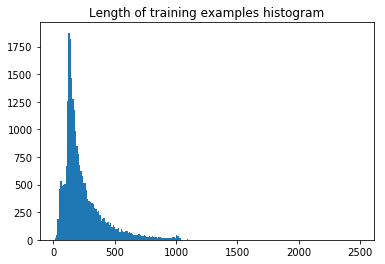

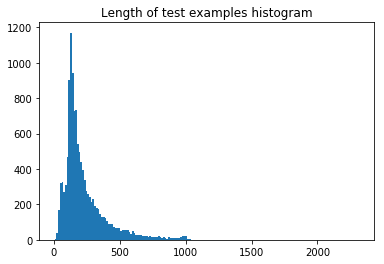

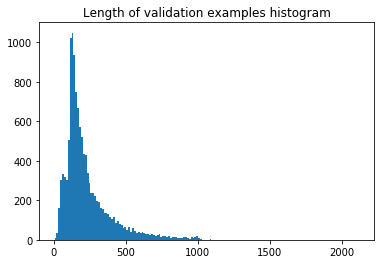

In [22]:
 x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=1)
print('training samples size : ', x_train.shape)
print('test samples size : ', x_test.shape)
print('validation samples size : ', x_val.shape)
lens = [len(x) for x in x_train]
plt.hist(lens, bins='auto')
plt.title('Length of training examples histogram')
plt.show()
maxlen = 0
maxlen = max(maxlen, np.max(lens))
lens = [len(x) for x in x_test]
plt.hist(lens, bins='auto')
plt.title('Length of test examples histogram')
plt.show()
maxlen = max(maxlen, np.max(lens))
lens = [len(x) for x in x_val]
plt.hist(lens, bins='auto')
plt.title('Length of validation examples histogram')
plt.show()
maxlen = max(maxlen, np.max(lens))

In [23]:
print('current max : ', maxlen)
maxlen = 500
print('our max : ', maxlen)
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
x_val = sequence.pad_sequences(x_val, maxlen=maxlen)

current max :  2494
our max :  500


In [24]:
print('training samples size : ', x_train.shape)
print('test samples size : ', x_test.shape)
print('validation samples size : ', x_val.shape)

training samples size :  (25000, 500)
test samples size :  (12500, 500)
validation samples size :  (12500, 500)


In [25]:
try:
    device_name = os.environ['COLAB_TPU_ADDR']
    TPU_ADDRESS = 'grpc://' + device_name
    print('Found TPU at: {}'.format(TPU_ADDRESS))

except KeyError:
    print('TPU not found')

batch_size = 64
epochs = 3
learning_rate = 0.001

TPU not found


In [0]:
def RnnModel(input_shape):
    model = Sequential()
    model.add(Embedding(num_words, 32, input_length=input_shape[1]))
    model.add(Dropout(0.2))
    model.add(SimpleRNN(1, activation = 'sigmoid'))
    return model
def LstmModel(input_shape):
    model = Sequential()
    model.add(Embedding(num_words, 32, input_length=input_shape[1]))
    model.add(Dropout(0.2))
    model.add(LSTM(1, activation = 'sigmoid'))
    return model
def GruModel(input_shape):
    model = Sequential()
    model.add(Embedding(num_words, 32, input_length=input_shape[1]))
    model.add(Dropout(0.2))
    model.add(GRU(1, activation = 'sigmoid'))
    return model
def DRnnModel(input_shape):
    model = Sequential()
    model.add(Embedding(num_words, 32, input_length=input_shape[1]))
    model.add(Dropout(0.2))
    model.add(SimpleRNN(100))
    model.add(Dropout(0.2))
    model.add(Dense(1,kernel_initializer = 'normal'))
    model.add(Activation('sigmoid'))
    return model
def DLstmModel(input_shape):
    model = Sequential()
    model.add(Embedding(num_words, 32, input_length=input_shape[1]))
    model.add(Dropout(0.2))
    model.add(LSTM(100))
    model.add(Dropout(0.2))
    model.add(Dense(1, kernel_initializer = 'normal'))
    model.add(Activation('sigmoid'))
    return model
def DGruModel(input_shape):
    model = Sequential()
    model.add(Embedding(num_words, 32, input_length=input_shape[1]))
    model.add(Dropout(0.2))
    model.add(GRU(100))
    model.add(Dropout(0.2))
    model.add(Dense(1, kernel_initializer = 'normal'))
    model.add(Activation('sigmoid'))
    return model
def test_model(train_X, train_y, val_X, val_y, test_X, test_y, Model, epochs=150, batch_size = 256, verbose = 0, learning_rate = 0.001):
  tup = ()
  tup = tup + (batch_size, )
  tup = tup + train_X.shape[1:]
  model = Model(tup)
  model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=AdamOptimizer(learning_rate))
  model.summary()
#   model = tf.contrib.tpu.keras_to_tpu_model(
#     model,
#     strategy=tf.contrib.tpu.TPUDistributionStrategy(
#         tf.contrib.cluster_resolver.TPUClusterResolver(TPU_ADDRESS)))
  history = model.fit(train_X, train_y, batch_size=batch_size, epochs=epochs, validation_data=(val_X, val_y),verbose = verbose)
  # Plot training & validation accuracy values
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()
  # Plot training & validation loss values
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()
  print('Last validation loss : ', history.history['val_loss'][-1], ' | last training loss : ', history.history['loss'][-1])
  print('Last validation accuracy : ', history.history['val_acc'][-1], ' | last training accuracy : ', history.history['acc'][-1])
  
  score, accuracy = model.evaluate(test_X, test_y, batch_size=batch_size, verbose=0)
  print("Test fraction correct (NN-Score) = {:.2f}".format(score))
  print("Test fraction correct (NN-Accuracy) = {:.2f}".format(accuracy))

Simple Rnn model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 500, 32)           64000     
_________________________________________________________________
dropout_4 (Dropout)          (None, 500, 32)           0         
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 1)                 34        
Total params: 64,034
Trainable params: 64,034
Non-trainable params: 0
_________________________________________________________________
Train on 25000 samples, validate on 12500 samples
Epoch 1/3
25000/25000 [==============================] - 180s 7ms/sample - loss: 0.6856 - acc: 0.5340 - val_loss: 0.6688 - val_acc: 0.5692
Epoch 2/3
25000/25000 [==============================] - 179s 7ms/sample - loss: 0.6520 - acc: 0.5931 - val_loss: 0.6655 - val_acc: 0.5748
Epoch 3/3
25000/25000 [==============================] - 

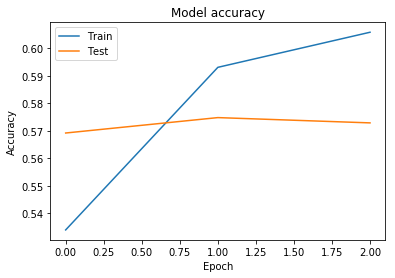

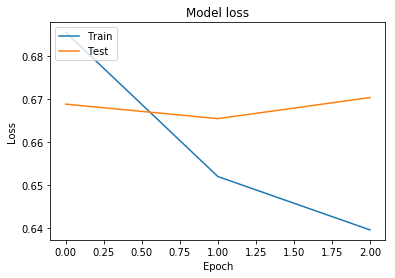

Last validation loss :  0.6703737602424622  | last training loss :  0.6395859066390991
Last validation accuracy :  0.57288  | last training accuracy :  0.60584
Test fraction correct (NN-Score) = 0.67
Test fraction correct (NN-Accuracy) = 0.57


In [27]:
print('Simple Rnn model')
test_model(x_train, y_train, x_val, y_val, x_test, y_test, RnnModel, epochs=epochs, batch_size = batch_size, verbose = 1)

Simple Lstm model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 500, 32)           64000     
_________________________________________________________________
dropout_5 (Dropout)          (None, 500, 32)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 1)                 136       
Total params: 64,136
Trainable params: 64,136
Non-trainable params: 0
_________________________________________________________________
Train on 25000 samples, validate on 12500 samples
Epoch 1/3
25000/25000 [==============================] - 479s 19ms/sample - loss: 0.6708 - acc: 0.5871 - val_loss: 0.6214 - val_acc: 0.6792
Epoch 2/3
25000/25000 [==============================] - 477s 19ms/sample - loss: 0.5896 - acc: 0.7112 - val_loss: 0.5833 - val_acc: 0.7149
Epoch 3/3
25000/25000 [==============================]

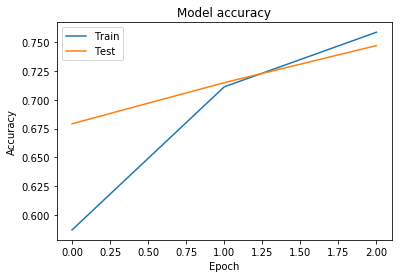

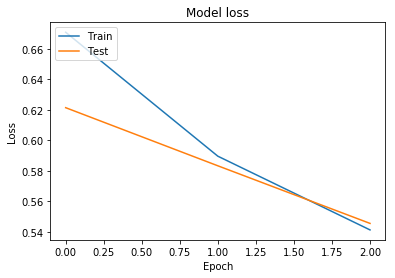

Last validation loss :  0.5455560908126831  | last training loss :  0.5412869456672669
Last validation accuracy :  0.74704  | last training accuracy :  0.75864
Test fraction correct (NN-Score) = 0.54
Test fraction correct (NN-Accuracy) = 0.75


In [28]:
print('Simple Lstm model')
test_model(x_train, y_train, x_val, y_val, x_test, y_test, LstmModel, epochs=epochs, batch_size = batch_size, verbose = 1)

Simple Gru model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 500, 32)           64000     
_________________________________________________________________
dropout_6 (Dropout)          (None, 500, 32)           0         
_________________________________________________________________
gru (GRU)                    (None, 1)                 102       
Total params: 64,102
Trainable params: 64,102
Non-trainable params: 0
_________________________________________________________________
Train on 25000 samples, validate on 12500 samples
Epoch 1/3
25000/25000 [==============================] - 411s 16ms/sample - loss: 0.6645 - acc: 0.6028 - val_loss: 0.6319 - val_acc: 0.6370
Epoch 2/3
25000/25000 [==============================] - 406s 16ms/sample - loss: 0.6015 - acc: 0.6693 - val_loss: 0.5978 - val_acc: 0.6608
Epoch 3/3
25000/25000 [==============================] 

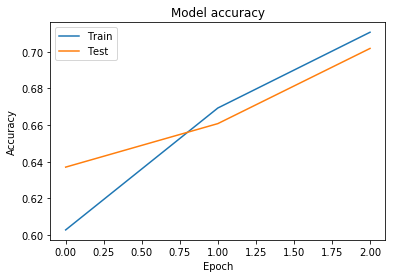

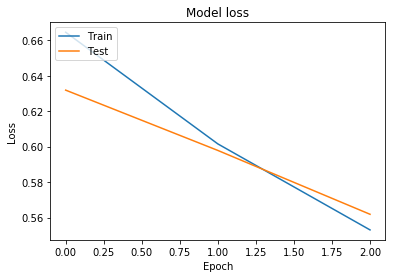

Last validation loss :  0.5618470436668396  | last training loss :  0.553029577217102
Last validation accuracy :  0.70184  | last training accuracy :  0.71068
Test fraction correct (NN-Score) = 0.56
Test fraction correct (NN-Accuracy) = 0.71


In [29]:
print('Simple Gru model')
test_model(x_train, y_train, x_val, y_val, x_test, y_test, GruModel, epochs=epochs, batch_size = batch_size, verbose = 1)

Rnn model with final dense layer
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 500, 32)           64000     
_________________________________________________________________
dropout_7 (Dropout)          (None, 500, 32)           0         
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 100)               13300     
_________________________________________________________________
dropout_8 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 77,401
Trainable params: 77,401
Non-trainable params: 0
_______________________________________

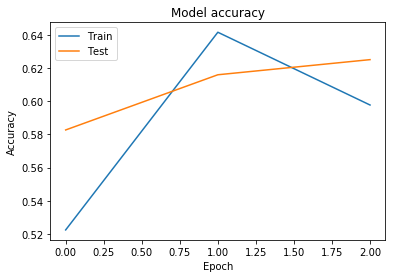

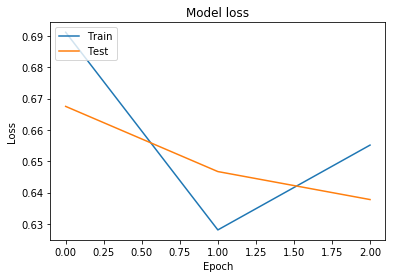

Last validation loss :  0.6377987948989868  | last training loss :  0.6551706651687622
Last validation accuracy :  0.62512  | last training accuracy :  0.59776
Test fraction correct (NN-Score) = 0.64
Test fraction correct (NN-Accuracy) = 0.62


In [30]:
print('Rnn model with final dense layer')
test_model(x_train, y_train, x_val, y_val, x_test, y_test, DRnnModel, epochs=epochs, batch_size = batch_size, verbose = 1)